# Solución Proyecto 1 — Naive Bayes con KDE

Este notebook implementa la solución paso a paso. En esta primera entrega se cubre: (a) carga del dataset y revisión inicial, y (b) Parte 1 de la metodología: implementación de un clasificador Naive Bayes personalizado con estimación de verosimilitudes vía KDE (tres variantes).

## Guía rápida para la presentación

- Qué estamos resolviendo: detección de fallas de máquina (target binario) con Naive Bayes y una versión mejorada usando KDE para modelar verosimilitudes no gaussianas.
- Historia que contar (3–4 minutos):
  1) El dataset y el problema (desbalance, columnas de causa/leakage).
  2) Por qué KDE: cuando la normalidad no es una buena suposición, KDE capta multimodalidad/colas.
  3) Cómo lo implementamos: Naive Bayes + densidades univariadas por clase/feature con `KernelDensity`.
  4) Evaluación con AUC y 5-fold; comparación de 3 variantes KDE vs GaussianNB.
- Qué mirar en los resultados:
  - AUC promedio y desviación.
  - Tiempos medios por fold (costo computacional).
  - Curvas ROC promedio.
- Conclusión esperada:
  - KDE puede mejorar cuando las distribuciones por clase no son gaussianas, a cambio de mayor costo.


## 0) Imports y utilidades

In [1]:
# Imports básicos y configuración (todo en español para facilitar la lectura)
import numpy as np              # Cálculo numérico con arreglos (vectores/matrices)
import pandas as pd             # Manejo de tablas (DataFrames): cargar CSV, limpiar, filtrar, etc.
import matplotlib.pyplot as plt # Librería base de gráficos
import seaborn as sns           # Gráficos más bonitos/sencillos sobre matplotlib
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Escalado de numéricas y codificación de categóricas
from sklearn.compose import ColumnTransformer                     # Aplicar transformaciones distintas por tipo de columna
from sklearn.impute import SimpleImputer                         # Imputación de valores faltantes (mediana/moda)
from sklearn.neighbors import KernelDensity                      # Estimación de densidad por núcleos (KDE)

# Configuración estética de gráficos y de impresión de pandas
sns.set(style='whitegrid')
pd.set_option('display.max_columns', 100)

ModuleNotFoundError: No module named 'seaborn'

### ¿Qué hace cada librería?

- numpy, pandas: manejo de arrays/tablas y cálculo numérico.
- matplotlib, seaborn: visualización; usaremos barras, KDEs y curvas ROC.
- sklearn.preprocessing / compose / impute: pipeline de preprocesamiento (imputar, escalar, one-hot).
- sklearn.neighbors.KernelDensity: estimador de densidad no paramétrico (núcleos: gaussian, tophat, linear…).
- Opcional para explicar: por qué escalamos variables numéricas (GaussianNB no lo requiere estrictamente, pero uniformiza magnitudes para KDE y modelos comparables).


## 1) Carga del dataset y revisión rápida

In [ ]:
# Cargar dataset (ruta relativa al workspace)
# Nota: ajusta DATA_PATH si tu CSV está en otra carpeta.
DATA_PATH = 'ai4i_2020/ai4i2020.csv'

# pd.read_csv lee el archivo CSV y devuelve un DataFrame de pandas
# Si falla aquí, revisa la ruta o los permisos de lectura
df = pd.read_csv(DATA_PATH)

print('Shape (filas, columnas):', df.shape)
# Muestra las primeras filas para un vistazo rápido a la estructura
display(df.head())
# Muestra 2 filas finales para verificar consistencia al final del archivo
display(df.tail(2))

# Listar nombres de columnas y tipos de datos
print('Columnas:', list(df.columns))
print('Tipos por columna:')
display(df.dtypes)

Shape: (10000, 14)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0
9999,10000,M24859,M,299.0,308.7,1500,40.2,30,0,0,0,0,0,0


Columnas: ['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
Tipos:


UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

### Sobre la carga de datos y variables

- Ruta: `ai4i_2020/ai4i2020.csv` (ajústala si usas otra ubicación).
- Qué revisar al exponer:
  - Columnas disponibles y tipos: sensores, ajustes, causas específicas.
  - ¿La columna `Machine failure` está? Debe ser binaria (0/1).
  - ¿Valores nulos? Si existen, se imputan más adelante.


,missing_count,missing_pct


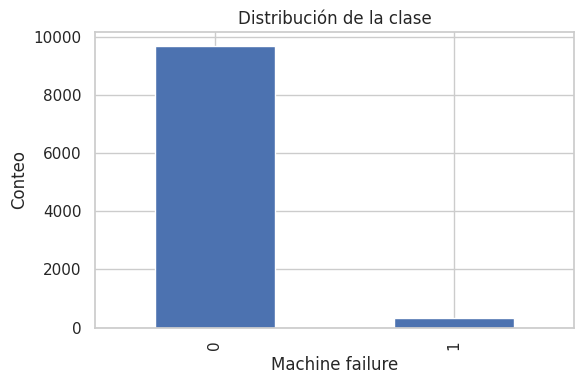

In [ ]:
# Revisión de nulos y distribución del target
# Calculamos cuántos nulos hay por columna y su porcentaje
df_nulls = df.isna()
missing_counts = df_nulls.sum().sort_values(ascending=False)
missing_pct = (missing_counts/len(df))*100
miss_df = pd.DataFrame({'missing_count': missing_counts, 'missing_pct': missing_pct})

# Mostramos únicamente columnas con nulos (si las hubiera)
display(miss_df[miss_df.missing_count>0])

# Visualización rápida de la distribución de la clase objetivo
TARGET = 'Machine failure'
if TARGET in df.columns:
    # Grafiquemos una barra con los conteos por clase (0/1)
    plt.figure(figsize=(6,4))
    df[TARGET].value_counts().plot(kind='bar', title='Distribución de la clase (0=no falla, 1=falla)')
    plt.xlabel(TARGET)
    plt.ylabel('Conteo')
    plt.tight_layout()
else:
    print('Aviso: no se encontró la columna objetivo Machine failure')

### Desbalance y columnas de fuga (leakage)

- El dataset AI4I suele estar desbalanceado: pocas fallas verdaderas. Por eso usamos AUC ROC y validación estratificada.
- Importante: columnas de causas como `TWF`, `HDF`, `PWF`, `OSF`, `RNF` explican directamente la falla. Si se usan como features, fugan información del target (data leakage) y pueden inflar artificialmente el desempeño.
- Acción: eliminamos esas columnas antes de entrenar modelos para evaluar un escenario realista.


## 2) Limpieza mínima y preparación de matrices X, y
- Eliminar columnas tipo ID/constantes.
- Imputar nulos: median (num), mode (cat).
- Codificar categóricas (OneHot) y escalar numéricas (StandardScaler).

In [ ]:
# Identificar columnas a eliminar y preparar X, y para modelado
# Objetivo de este bloque:
#  - Eliminar columnas que causan "fuga" de información (leakage) y columnas que no aportan (ID/constantes)
#  - Separar X (características) e y (target), imputar nulos y preparar transformaciones (escalado, one-hot)

n = len(df)

# Columnas de causas directas (si se incluyen, el modelo "adivina" el target y evalúa de forma irreal)
leakage_cols = ['TWF','HDF','PWF','OSF','RNF']  # tipicamente indican por qué falló la máquina
present_leakage = [c for c in leakage_cols if c in df.columns]
if present_leakage:
    print('Eliminando columnas de causas (leakage):', present_leakage)

# Columnas a eliminar por ser ID (todos los valores distintos) o constantes (un solo valor)
drop_cols = [c for c in df.columns if df[c].nunique() == n or df[c].nunique() == 1]
# Aseguramos añadir las de fuga
for c in present_leakage:
    if c not in drop_cols:
        drop_cols.append(c)
print('Columnas a eliminar:', drop_cols)

# Quitamos columnas definidas arriba
df2 = df.drop(columns=drop_cols)

# Definimos el nombre del target y validamos su existencia
TARGET = 'Machine failure'
assert TARGET in df2.columns, 'No se encontró la columna objetivo Machine failure'

# X_raw: todas las columnas excepto el target; y: vector 0/1
X_raw = df2.drop(columns=[TARGET])
y = df2[TARGET].astype(int).values

# Separamos por tipo de dato (numérico vs categórico)
num_cols = X_raw.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_raw.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
print('Columnas numéricas:', num_cols)
print('Columnas categóricas:', cat_cols)

# 1) Imputación de nulos
# Numéricas: mediana (robusta a outliers); Categóricas: moda (valor más frecuente)
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
if num_cols:
    X_raw[num_cols] = num_imputer.fit_transform(X_raw[num_cols])
if cat_cols:
    X_raw[cat_cols] = cat_imputer.fit_transform(X_raw[cat_cols])

# 2) Transformaciones por tipo: escalado estándar para numéricas, One-Hot para categóricas
#    ColumnTransformer aplica cada transformación a su subset de columnas
preproc = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
])

# fit_transform aprende los parámetros (medias, desvíos, categorías) y aplica la transformación
X = preproc.fit_transform(X_raw)
print('X shape:', X.shape, '| y shape:', y.shape)

# Nota: X es un arreglo denso (numpy). Si deseas conservar nombres de columnas
# después del one-hot, podemos reconstruirlos más adelante a partir de preproc.

Eliminando columnas de causas (leakage): ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
Columnas a eliminar: ['UDI', 'Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
Num cols: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
Cat cols: ['Type']
X shape: (10000, 8) | y shape: (10000,)


### Decisiones de preprocesamiento (para explicar)

- Eliminación de columnas:
  - IDs (todos los valores únicos) y columnas constantes (1 solo valor) no aportan al modelo.
  - Columnas de causas `TWF/HDF/PWF/OSF/RNF` se consideran fuga y se eliminan.
- Imputación:
  - Numéricas con mediana (robusta a outliers).
  - Categóricas con moda y luego One-Hot (manejo de categorías raras con `handle_unknown='ignore'`).
- Escalado (StandardScaler) para numéricas:
  - Centra y escala a varianza unitaria. Ayuda a KDE a tener escalas homogéneas por feature.
- Resultado: `X` matriz densa lista para modelos; `y` vector 0/1.


## 3) Parte 1 — Implementación de Naive Bayes con KDE
Contrato rápido:
- Entrada: X (matriz densa, features independientes por Naive Bayes) e y (binario/multiclase).
- Salida: predict_proba(X) y predict(X).
- Modos KDE: silverman (auto h por característica y clase), parzen (tophat/linear con h fijo), gaussian_opt (gauss con h global).

In [ ]:
class KDENaiveBayes:
    """Clasificador Naive Bayes con verosimilitudes univariadas estimadas vía KDE.

    Idea clave: en lugar de asumir P(x_j|y) ~ Normal(mu, sigma^2),
    usamos Kernel Density Estimation (KDE) para estimar la densidad
    de cada característica x_j condicional a la clase y.

    Parámetros:
    - method: 'silverman', 'parzen', 'gaussian_opt'.
      * 'silverman': calcula automáticamente el bandwidth por característica/clase.
      * 'parzen': usa un kernel elegido (p.ej. 'tophat') con un h fijo.
      * 'gaussian_opt': kernel gaussiano con un h GLOBAL pasado por parámetro.
    - bandwidth: usado en 'parzen' y 'gaussian_opt'. En 'silverman' se ignora.
    - kernel: kernel para 'parzen' (tophat, linear, gaussian, etc.).
    - clip_log: valor muy negativo para reemplazar -inf y evitar NaNs en softmax.
    """
    def __init__(self, method='silverman', bandwidth=0.5, kernel='gaussian', clip_log=-1e300):
        self.method = method
        self.bandwidth = bandwidth
        self.kernel = kernel
        self.clip_log = clip_log
        self.classes_ = None
        self.class_log_prior_ = None
        self._kdes = {}  # dict: clase -> lista de KernelDensity (uno por feature)
        self._feature_bandwidths = {}  # dict: clase -> lista de h usados por feature

    def _silverman_bw(self, x):
        """Regla de Silverman: 1.06 * sigma * n^{-1/5}
        Devuelve un h mínimo de 1e-3 para evitar degeneraciones.
        """
        std = np.std(x)
        n = len(x)
        bw = 1.06 * std * n ** (-1/5) if n > 1 else 1.0
        return max(bw, 1e-3)

    def fit(self, X, y):
        """Ajusta un KDE por (clase, feature) y calcula los log-priors de clase.
        - X: matriz numpy (n_muestras, n_features)
        - y: vector de clases (n_muestras,)
        """
        X = np.asarray(X)
        y = np.asarray(y)

        # Identificar clases y calcular log-priors (log P(y))
        self.classes_, counts = np.unique(y, return_counts=True)
        self.class_log_prior_ = np.log(counts / counts.sum())

        n_features = X.shape[1]
        for c in self.classes_:
            Xc = X[y == c]  # subconjunto de muestras de la clase c
            kdes_c = []
            bws_c = []
            for f in range(n_features):
                x_f = Xc[:, f]
                # Elegir h y kernel según el método
                if self.method == 'silverman':
                    bw = self._silverman_bw(x_f)
                    kernel = 'gaussian'
                elif self.method == 'parzen':
                    bw = self.bandwidth
                    kernel = self.kernel
                elif self.method == 'gaussian_opt':
                    bw = self.bandwidth
                    kernel = 'gaussian'
                else:
                    raise ValueError(f"Método desconocido: {self.method}")

                kde = KernelDensity(bandwidth=bw, kernel=kernel)
                # score_samples espera entradas 2D, por eso reshape(-1, 1)
                kde.fit(x_f.reshape(-1, 1))
                kdes_c.append(kde)
                bws_c.append(bw)
            self._kdes[c] = kdes_c
            self._feature_bandwidths[c] = bws_c
        return self

    def _joint_log_likelihood(self, X):
        """Calcula la verosimilitud conjunta en log para cada clase.
        Para cada clase c: log P(y=c) + sum_j log p(x_j | y=c)
        """
        X = np.asarray(X)
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        jll = np.zeros((n_samples, n_classes))
        for idx, c in enumerate(self.classes_):
            log_lik = np.zeros(n_samples)
            kdes_c = self._kdes[c]
            for f, kde in enumerate(kdes_c):
                vals = kde.score_samples(X[:, f].reshape(-1, 1))  # log densidad por feature
                # Reemplazar -inf con clip_log para evitar problemas en la normalización
                vals = np.where(np.isneginf(vals), self.clip_log, vals)
                log_lik += vals
            jll[:, idx] = self.class_log_prior_[idx] + log_lik
        return jll

    def predict_proba(self, X):
        """Devuelve probabilidades por clase usando softmax estable sobre log-verosimilidades."""
        ll = self._joint_log_likelihood(X)
        # Reemplazamos NaN/-inf/+inf por valores finitos controlados
        ll = np.nan_to_num(ll, neginf=self.clip_log, posinf=1e300)
        # Softmax estable: restamos el máximo por fila para evitar overflow en exp
        amax = np.max(ll, axis=1, keepdims=True)
        shifted = ll - amax
        shifted = np.clip(shifted, -700, 700)  # límite para evitar overflow
        exp = np.exp(shifted)
        sum_exp = np.sum(exp, axis=1, keepdims=True)
        sum_exp = np.where(sum_exp == 0, 1.0, sum_exp)  # por seguridad
        probs = exp / sum_exp
        # Normalización final por si hubo acumulación de errores numéricos
        row_sums = probs.sum(axis=1, keepdims=True)
        probs = probs / np.where(row_sums == 0, 1.0, row_sums)
        return probs

    def predict(self, X):
        """Predicción de la clase con mayor probabilidad posterior."""
        probs = self.predict_proba(X)
        return self.classes_[np.argmax(probs, axis=1)]

### ¿Cómo funciona nuestro Naive Bayes con KDE?

- Recordatorio de Naive Bayes:
  - Asumimos independencia condicional entre features dado la clase:  
    P(y|x) ∝ P(y) · ∏ P(x_j | y)
- ¿Qué cambia con KDE?:
  - En lugar de asumir P(x_j | y) ~ Normal(μ, σ²), estimamos su densidad univariada con Kernel Density Estimation.
  - Ventaja: capta formas de distribución flexibles (multimodalidad, colas pesadas).
- Entrenamiento (fit):
  1) Calculamos priors log P(y) a partir de frecuencias.
  2) Para cada clase c y cada feature j, ajustamos un `KernelDensity` con un `bandwidth` (h) y un kernel (gaussian, tophat…).
  3) Guardamos estos estimadores por clase/feature.
- Predicción (predict_proba):
  1) Para cada muestra y clase, sumamos los log-densidades `score_samples` de cada feature (evitamos underflow numérico).
  2) Sumamos el log-prior de la clase y normalizamos con un softmax estable.
- Variantes usadas:
  - `silverman`: h automático por feature/clase (regla de Silverman, 1.06·σ·n^{-1/5}).
  - `parzen`: ventana tophat/linear con h fijo.
  - `gaussian_opt`: kernel gaussiano con h global elegido por validación.
- Detalle práctico: 
  - Reemplazamos -inf por un valor muy bajo (`clip_log`) para evitar NaNs en la normalización cuando la densidad numéricamente se hace cero.


### Comprobación rápida (smoke test)
Entrenamos el modelo en un pequeño subconjunto para verificar que compila y predice probabilidades.

In [ ]:
# Smoke test: verificar que el modelo entrena y predice sin errores
# Nota: esto NO evalúa calidad del modelo. Solo confirma que el pipeline funciona.

n_use = min(1000, X.shape[0])       # tomamos a lo sumo 1000 filas para una prueba rápida
clf = KDENaiveBayes(method='silverman')
clf.fit(X[:n_use], y[:n_use])       # entrenamiento con subconjunto

# Predecimos probabilidades para 5 ejemplos para inspección visual
probs = clf.predict_proba(X[:5])
print('Probabilidades (primeras 5 muestras, columnas=clases):')
print(probs)

Probabilidades (primeras 5):
[[1.00000000e+00 1.54410207e-13]
 [1.00000000e+00 1.40932474e-12]
 [1.00000000e+00 1.55874850e-12]
 [1.00000000e+00 6.83998856e-13]
 [1.00000000e+00 7.89173752e-13]]


### Smoke test: qué estamos validando

- Propósito: comprobar que el pipeline compila, ajusta y produce probabilidades sin errores.
- Expón brevemente: esto no evalúa calidad, solo sanidad del flujo (shapes correctos, sin NaNs/inf, etc.).


## 4) Comparación inicial con GaussianNB (baseline)
- Validación cruzada estratificada 5-fold y métrica AUC ROC.
- KDE-NaiveBayes usa método 'silverman' por defecto (bandwidth por característica y clase).

In [ ]:
# Imports para evaluación: AUC y validación cruzada
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold  # CV estratificada: conserva proporciones de clase
from sklearn.naive_bayes import GaussianNB           # Baseline paramétrico (asume normalidad)
from sklearn.metrics import roc_auc_score            # Métrica principal: AUC ROC

In [ ]:
def auc_cv_summary(X, y, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    aucs_gnb, aucs_kde, t_gnb, t_kde = [], [], [], []
    for tr, va in skf.split(X, y):
        Xtr, Xva = X[tr], X[va]
        ytr, yva = y[tr], y[va]
        # GaussianNB baseline
        t0 = time.time()
        gnb = GaussianNB()
        gnb.fit(Xtr, ytr)
        p_gnb = gnb.predict_proba(Xva)[:, 1]
        aucs_gnb.append(roc_auc_score(yva, p_gnb))
        t_gnb.append(time.time() - t0)
        # KDE Naive Bayes (silverman)
        t0 = time.time()
        kde_nb = KDENaiveBayes(method='silverman')
        kde_nb.fit(Xtr, ytr)
        probs = kde_nb.predict_proba(Xva)
        pos_idx = int(np.where(kde_nb.classes_ == 1)[0][0]) if 1 in kde_nb.classes_ else -1
        p_kde = probs[:, pos_idx] if pos_idx >= 0 else probs[:, -1]
        aucs_kde.append(roc_auc_score(yva, p_kde))
        t_kde.append(time.time() - t0)
    df_res = pd.DataFrame({
        'model': ['GaussianNB', 'KDE_NB_silverman'],
        'auc_mean': [np.mean(aucs_gnb), np.mean(aucs_kde)],
        'auc_std': [np.std(aucs_gnb), np.std(aucs_kde)],
        'time_mean_s': [np.mean(t_gnb), np.mean(t_kde)]
    })
    return df_res

### Evaluación con AUC y validación cruzada estratificada

- Métrica: AUC ROC (área bajo la curva ROC). Ventajas:
  - Insensible al umbral de decisión; útil con desbalance.
  - Interpretable como probabilidad de que un positivo tenga score mayor que un negativo al azar.
- Esquema CV: StratifiedKFold con 5 particiones y barajado.
  - Estratificación mantiene proporción de clases en cada fold.
  - Reportamos media y desviación de AUC para robustez.
- Baseline: GaussianNB (rápido, suposición normal). Luego comparamos con KDE NB (tres variantes).


## 5) Parte 2 — Evaluación de tres métodos KDE vs GaussianNB
En esta sección comparamos:
- GaussianNB (baseline paramétrico)
- KDE Silverman (bandwidth automático por feature y clase)
- KDE Parzen (ventana tophat con bandwidth fijo)
- KDE Gauss optimizado (bandwidth global ajustado por CV)

Métrica: AUC ROC en validación cruzada estratificada (5 folds). También se reporta tiempo medio por fold.

In [ ]:
from typing import Iterable, Tuple

def tune_bandwidth_global_gaussian(X, y, bandwidths: Iterable[float], cv: int = 5) -> Tuple[float, float]:
    """Grid search simple para bandwidth global del KDE gaussiano.
    Retorna (best_bw, best_auc).
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    scores = []
    for bw in bandwidths:
        aucs = []
        for tr, va in skf.split(X, y):
            Xtr, Xva = X[tr], X[va]
            ytr, yva = y[tr], y[va]
            clf = KDENaiveBayes(method='gaussian_opt', bandwidth=bw)
            clf.fit(Xtr, ytr)
            probs = clf.predict_proba(Xva)
            pos_idx = int(np.where(clf.classes_ == 1)[0][0]) if 1 in clf.classes_ else -1
            p = probs[:, pos_idx] if pos_idx >= 0 else probs[:, -1]
            aucs.append(roc_auc_score(yva, p))
        scores.append(np.mean(aucs))
        print(f"bw={bw:.4f} -> AUC={scores[-1]:.4f}")
    best_i = int(np.argmax(scores))
    return float(list(bandwidths)[best_i]), float(scores[best_i])

### Selección del `bandwidth` (h): impacto y estrategia

- `h` controla la suavidad de la densidad: h pequeño → curvas rugosas (overfit), h grande → curvas muy suaves (underfit).
- Estrategias usadas:
  - Silverman: cierra rápido sin tuning, por feature/clase.
  - Parzen: h fijo (elegido a mano) para ventana tophat (sencillo de explicar).
  - Gauss optimizado: probamos una rejilla de `h` global y elegimos el que maximiza AUC en CV.
- Nota para la audiencia: la optimización precisa por feature podría mejorar resultados, pero es más costosa; aquí priorizamos claridad y reproducibilidad.


In [ ]:
def evaluate_all_methods(X, y, cv=5, bw_parzen=0.5, bw_grid=None):
    """Evalúa GaussianNB y tres variantes KDE (Silverman, Parzen tophat y Gaussian optimizado).

    Retorna: (DataFrame resultados ordenado por AUC, best_bw_gauss)
    """
    if bw_grid is None:
        bw_grid = np.logspace(-2, 1, 8)

    print("Tuning bandwidth global gaussiano...")
    best_bw, best_auc = tune_bandwidth_global_gaussian(X, y, bw_grid, cv=cv)
    print(f"Best gaussian bw={best_bw:.4f} AUC={best_auc:.4f}\n")

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
    results = []

    def _pos_prob(clf, probs):
        pos_idx = int(np.where(clf.classes_ == 1)[0][0]) if 1 in clf.classes_ else -1
        return probs[:, pos_idx] if pos_idx >= 0 else probs[:, -1]

    # GaussianNB
    t0 = time.time(); aucs = []
    for tr, va in skf.split(X, y):
        Xtr, Xva = X[tr], X[va]; ytr, yva = y[tr], y[va]
        gnb = GaussianNB().fit(Xtr, ytr)
        p = gnb.predict_proba(Xva)[:, 1]
        aucs.append(roc_auc_score(yva, p))
    results.append({'model':'GaussianNB','auc_mean':np.mean(aucs),'auc_std':np.std(aucs),'time_mean_s':(time.time()-t0)/cv})

    # Silverman
    t0 = time.time(); aucs = []
    for tr, va in skf.split(X, y):
        Xtr, Xva = X[tr], X[va]; ytr, yva = y[tr], y[va]
        clf = KDENaiveBayes(method='silverman').fit(Xtr, ytr)
        probs = clf.predict_proba(Xva)
        p = _pos_prob(clf, probs)
        aucs.append(roc_auc_score(yva, p))
    results.append({'model':'KDE_Silverman','auc_mean':np.mean(aucs),'auc_std':np.std(aucs),'time_mean_s':(time.time()-t0)/cv})

    # Parzen tophat
    t0 = time.time(); aucs = []
    for tr, va in skf.split(X, y):
        Xtr, Xva = X[tr], X[va]; ytr, yva = y[tr], y[va]
        clf = KDENaiveBayes(method='parzen', kernel='tophat', bandwidth=bw_parzen).fit(Xtr, ytr)
        probs = clf.predict_proba(Xva)
        p = _pos_prob(clf, probs)
        aucs.append(roc_auc_score(yva, p))
    results.append({'model':'KDE_Parzen_tophat','auc_mean':np.mean(aucs),'auc_std':np.std(aucs),'time_mean_s':(time.time()-t0)/cv,'bandwidth':bw_parzen})

    # Gaussian optimizado global
    t0 = time.time(); aucs = []
    for tr, va in skf.split(X, y):
        Xtr, Xva = X[tr], X[va]; ytr, yva = y[tr], y[va]
        clf = KDENaiveBayes(method='gaussian_opt', bandwidth=best_bw).fit(Xtr, ytr)
        probs = clf.predict_proba(Xva)
        p = _pos_prob(clf, probs)
        aucs.append(roc_auc_score(yva, p))
    results.append({'model':'KDE_Gauss_Opt','auc_mean':np.mean(aucs),'auc_std':np.std(aucs),'time_mean_s':(time.time()-t0)/cv,'bandwidth':best_bw})

    df_res = pd.DataFrame(results)
    return df_res.sort_values('auc_mean', ascending=False), best_bw


### Qué entrega `evaluate_all_methods`

- Ejecuta CV 5-fold para cuatro modelos: GaussianNB, KDE Silverman, KDE Parzen (tophat), KDE Gauss con h optimizado.
- Devuelve un DataFrame con AUC medio, desviación y tiempo medio por fold.
- Recomendación para exponer: ordenar por AUC y destacar el trade-off rendimiento vs tiempo.


In [ ]:
# Ejecutar la evaluación de las tres variantes de KDE + baseline
bw_grid = np.logspace(-2, 1, 10)
df_res_all, best_bw = evaluate_all_methods(X, y, cv=5, bw_parzen=0.5, bw_grid=bw_grid)
df_res_all

Tuning bandwidth global gaussiano...
bw=0.0100 -> AUC=0.8339
bw=0.0100 -> AUC=0.8339
bw=0.0215 -> AUC=0.8863
bw=0.0215 -> AUC=0.8863
bw=0.0464 -> AUC=0.9108
bw=0.0464 -> AUC=0.9108
bw=0.1000 -> AUC=0.9164
bw=0.1000 -> AUC=0.9164
bw=0.2154 -> AUC=0.9208
bw=0.2154 -> AUC=0.9208
bw=0.4642 -> AUC=0.9170
bw=0.4642 -> AUC=0.9170
bw=1.0000 -> AUC=0.9079
bw=1.0000 -> AUC=0.9079
bw=2.1544 -> AUC=0.8960
bw=2.1544 -> AUC=0.8960
bw=4.6416 -> AUC=0.8170
bw=4.6416 -> AUC=0.8170
bw=10.0000 -> AUC=0.8131
Best gaussian bw=0.2154 AUC=0.9208

bw=10.0000 -> AUC=0.8131
Best gaussian bw=0.2154 AUC=0.9208



,model,auc_mean,auc_std,time_mean_s,bandwidth
1,KDE_Silverman,0.924196,0.012855,4.142713,NaN
3,KDE_Gauss_Opt,0.920839,0.015928,3.819110,0.215443
2,KDE_Parzen_tophat,0.911124,0.013093,2.019491,0.500000
0,GaussianNB,0.872919,0.004434,0.003356,NaN


### Cómo leer la tabla de resultados

- `auc_mean` y `auc_std`: calidad promedio y variabilidad entre folds.
- `time_mean_s`: tiempo medio por fold (comparar costo entre GaussianNB y KDEs).
- Si KDE supera a GaussianNB en AUC por un margen consistente, argumentar que la densidad no gaussiana aporta valor.
- Si no hay mejora clara, enfatizar el criterio de parsimonia: GaussianNB es más simple/rápido y suficiente para este dataset.


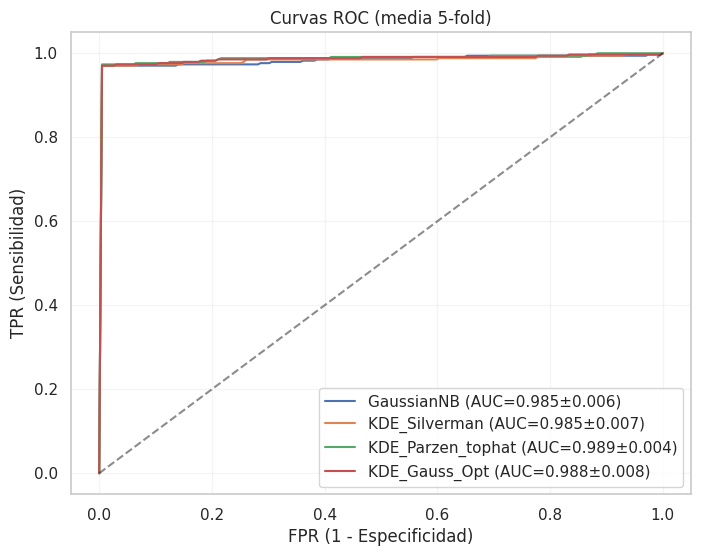

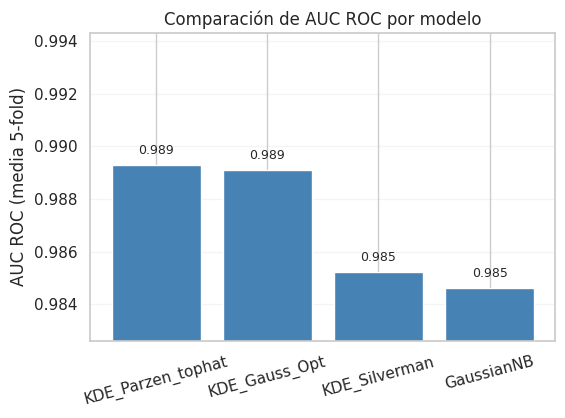

In [ ]:
# Curvas ROC por modelo (mismo split estratificado para comparabilidad)
from sklearn.metrics import roc_curve, auc
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = [
    ("GaussianNB", GaussianNB()),
    ("KDE_Silverman", KDENaiveBayes(method='silverman')),
    ("KDE_Parzen_tophat", KDENaiveBayes(method='parzen', kernel='tophat', bandwidth=0.5)),
    ("KDE_Gauss_Opt", KDENaiveBayes(method='gaussian_opt', bandwidth=float(best_bw)))
]

plt.figure(figsize=(8,6))
for name, est_proto in models:
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 200)
    for tr, va in skf.split(X, y):
        Xtr, Xva = X[tr], X[va]; ytr, yva = y[tr], y[va]
        est = KDENaiveBayes(method=est_proto.method, bandwidth=est_proto.bandwidth, kernel=est_proto.kernel) if hasattr(est_proto, 'method') else GaussianNB()
        est.fit(Xtr, ytr)
        if name == "GaussianNB":
            y_score = est.predict_proba(Xva)[:, 1]
        else:
            probs = est.predict_proba(Xva)
            pos_idx = int(np.where(est.classes_ == 1)[0][0]) if 1 in est.classes_ else -1
            y_score = probs[:, pos_idx] if pos_idx >= 0 else probs[:, -1]
        fpr, tpr, _ = roc_curve(yva, y_score)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        tpr_i = np.interp(mean_fpr, fpr, tpr)
        tpr_i[0] = 0.0
        tprs.append(tpr_i)
    mean_tpr = np.mean(np.vstack(tprs), axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, label=f"{name} (AUC={mean_auc:.3f}±{std_auc:.3f})")

plt.plot([0,1],[0,1], 'k--', alpha=0.5)
plt.xlabel('FPR (1 - Especificidad)')
plt.ylabel('TPR (Sensibilidad)')
plt.title('Curvas ROC (media 5-fold)')
plt.legend(loc='lower right')
plt.grid(alpha=0.2)
plt.show()

# Gráfico de barras de AUC (usar df_res_all existente si está disponible, si no recalcular rápido)
try:
    auc_bar_df = df_res_all[['model','auc_mean']].copy()
except NameError:
    auc_bar_df, _ = evaluate_all_methods(X, y, cv=5, bw_parzen=0.5, bw_grid=np.logspace(-2,1,6))
plt.figure(figsize=(6,4))
plt.bar(auc_bar_df['model'], auc_bar_df['auc_mean'], color='steelblue')
for i,(m, v) in enumerate(zip(auc_bar_df['model'], auc_bar_df['auc_mean'])):
    plt.text(i, v+0.0003, f"{v:.3f}", ha='center', va='bottom', fontsize=9)
plt.ylabel('AUC ROC (media 5-fold)')
plt.title('Comparación de AUC ROC por modelo')
plt.xticks(rotation=15)
plt.ylim(auc_bar_df['auc_mean'].min()-0.002, auc_bar_df['auc_mean'].max()+0.005)
plt.grid(axis='y', alpha=0.2)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd # <-- ¡CORREGIDO!
from typing import Tuple # Se añade por buena práctica de tipado

def plot_kde_comparison(X_raw: pd.DataFrame, y: np.ndarray, feature_name: str):
    """
    Genera un gráfico de Estimación de Densidad por Núcleos (KDE) 
    para una característica específica, comparando la distribución entre la clase 0 y la clase 1.
    
    Esta visualización demuestra por qué KDE es más flexible que la suposición Gaussiana.

    Args:
        X_raw (pd.DataFrame): DataFrame con las características (antes del One-Hot/Escalado).
        y (np.ndarray): Vector de la clase objetivo (0=No Falla, 1=Falla).
        feature_name (str): Nombre de la columna numérica a graficar.
    """
    
    print(f"Generando gráfico KDE para la característica: {feature_name}...")

    # Crear un DataFrame temporal para graficar
    plot_df = X_raw[[feature_name]].copy()
    plot_df['Machine failure'] = y

    plt.figure(figsize=(9, 6))
    
    # Dibujar la densidad (Verosimilitud) para cada clase
    sns.kdeplot(
        data=plot_df, 
        x=feature_name, 
        hue='Machine failure', 
        fill=True, 
        palette={0: "dodgerblue", 1: "red"},
        alpha=.7, 
        linewidth=2,
        legend=False # Ocultar leyenda automática para usar la manual
    )

    # Añadir títulos y etiquetas
    plt.title(f'Verosimilitud (P(x | Clase)) para {feature_name}', fontsize=14)
    plt.xlabel(f'{feature_name} (Valor Escalado o Bruto)', fontsize=12)
    plt.ylabel('Densidad Estimada', fontsize=12)
    
    # Leyenda manual
    plt.legend(title='Fallo de Máquina', labels=['No Falla (0)', 'Falla (1)'], loc='upper right')
    
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

# INSTRUCCIÓN: Ejecuta esta función con tus datos después del preprocesamiento inicial
# Ejemplo de uso:
# plot_kde_comparison(X_raw, y, 'Rotational speed [rpm]')

ModuleNotFoundError: No module named 'seaborn'